# Mesh VPN Performance

## Convert binary `.data` files to `.json`

In [1]:
import subprocess
from pathlib import Path
import json
import csv
import re
import pandas as pd
import seaborn
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import itertools
import numpy as np

In [ ]:
"""
In certain cases KNB produces invalid JSON files, this is a hacky way of fixing those.
"""
def clean_json(input_str: str):
    replacement_str = input_str.replace('''      }
    },
  }''', '''      }
    }
  }''')
    replacement_str = replacement_str.replace('"user": ,', '"user": -1,')
    replacement_str = replacement_str.replace('"bandwidth": ,', '"bandwidth": -1,')
    replacement_str = replacement_str.replace('"nice": ,', '"nice": -1,')
    replacement_str = replacement_str.replace('"system": ,', '"system": -1,')
    replacement_str = replacement_str.replace('"iowait": ,', '"iowait": -1,')
    replacement_str = replacement_str.replace('"steal": \n', '"steal": -1\n')
    replacement_str = replacement_str.replace('"ram": \n', '"ram": -1\n')
    return replacement_str

In [ ]:
def extract_test_conditions(file_name: str):
    res = re.findall(r'loss(\d+).*delay(\d+)', file_name)
    loss = res[0][0]
    delay = res[0][1]
    # [0]=loss; [1]=delay
    return loss, delay

def extract_test_type_test_conditions(file_name: str):
    res = re.findall(r'-(idle|p2ptcp|p2pudp)-loss(\d+).*delay(\d+)', file_name)
    # [0]=loss; [1]=delay
    if res[0][0] == 'p2ptcp':
        benchmark_type = 'pod2pod'
        transport_protocol = 'tcp'
    elif res[0][0] == 'p2pudp':
        benchmark_type = 'pod2pod'
        transport_protocol = 'udp'
    elif res[0][0] == 'idle':
        benchmark_type = 'idle'
        transport_protocol = 'idle'
    else:
        print('UNIDENTIFIED CONDITIONS: ', res[0][0])
        return -1
    loss = res[0][1]
    delay = res[0][2]
    return benchmark_type, transport_protocol, loss, delay

In [ ]:
RAW_SOURCE_FILES_DIR=Path('results-raw/02-separate-vlans-topology')
JSON_RESULTS_DIR='results-json'

In [ ]:
"""
Create directory structure in the results-json directory. Example:
    - results-json/11-native-mtu1230
    - results-json/12-native-mtu1450
"""
for raw_source_dir in list(RAW_SOURCE_FILES_DIR.iterdir()):
    json_source_dir = Path(f'{JSON_RESULTS_DIR}/{raw_source_dir.name}')
    if not json_source_dir.exists():
        print(f'{json_source_dir.name} does not exist, creating it now...')
        json_source_dir.mkdir()
    for sub_raw_dir in list(raw_source_dir.iterdir()):
        output_dir = raw_source_dir.name
        file_name = sub_raw_dir.name
        # Example: 12-native-mtu1450/01-native-mtu1450-60s-p2pudp-loss0p-delay350ms
        print(f'Path {raw_source_dir.name}/{sub_raw_dir.name}')
        results = []
        """
        Merge all measurements of a given type for a given VPN in a single JSON file.
        """
        for result in list(sub_raw_dir.iterdir()):
            if result.is_file() and result.name.endswith('.data'):
                print(result.resolve())
                json_str_output = subprocess.run(['knb', '--from-data', result.resolve(), '--output', 'json'],capture_output=True,
                                                 text=True)
                json_object = json.loads(clean_json(json_str_output.stdout))
                results.append(json_object)
        with open(f'{JSON_RESULTS_DIR}/{output_dir}/{file_name}.json', 'w') as jf:
            json.dump(results, jf)

## Merge `.json` files

In [ ]:
BENCHMARK_TYPES = ['idle', 'pod2pod', 'pod2svc']
CSV_FIELDS = ['benchmark-name', 'benchmark-type', 'server-node', 'client-node', 'socket-buffer-size', 'mtu', 'bandwidth', 'client-ram', 'client-cpu', 'server-ram', 'server-cpu', 'transport-protocol', 'loss', 'delay']

In [ ]:
def process_aio_benchmark(json_files_dir:str):
    with open(f'{json_files_dir}/all.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(CSV_FIELDS)
        for _file in Path(RESULTS_PATH).glob('*.json'):
            print(_file)
            with open(_file, 'r') as iff:
                results = json.load(iff)
                loss,delay=extract_test_conditions(_file.name)
                for result in results:
                    server_node = result['metadata']['server-node']
                    client_node = result['metadata']['client-node']
                    socket_buffer_size = result['metadata']['socket-buffer-size']
                    mtu = result['data']['mtu']
                    for _type in BENCHMARK_TYPES:
                        if _type == 'idle':
                            if result['data'].get(_type) is not None:
                                bandwidth = result['data'][_type]['bandwidth']
                                client_ram = result['data'][_type]['client']['ram']
                                client_cpu = result['data'][_type]['client']['cpu']['total']
                                server_ram = result['data'][_type]['server']['ram']
                                server_cpu = result['data'][_type]['server']['cpu']['total']
                                transport_protocol = 'idle'
                                writer.writerow([BENCHMARK_NAME, _type, server_node, client_node, socket_buffer_size, mtu, bandwidth, client_ram, client_cpu, server_ram, server_cpu, transport_protocol,loss,delay])
                        else:
                            for protocol in ['tcp', 'udp']:
                                if result['data'][_type].get(protocol) is not None:
                                    bandwidth = result['data'][_type][protocol]['bandwidth']
                                    client_ram = result['data'][_type][protocol]['client']['ram']
                                    client_cpu = result['data'][_type][protocol]['client']['cpu']['total']
                                    server_ram = result['data'][_type][protocol]['server']['ram']
                                    server_cpu = result['data'][_type][protocol]['server']['cpu']['total']
                                    transport_protocol = protocol
                                    writer.writerow([BENCHMARK_NAME, _type, server_node, client_node, socket_buffer_size, mtu, bandwidth, client_ram, client_cpu, server_ram, server_cpu, transport_protocol,loss,delay])

In [ ]:
def process_separate_benchmark(json_files_dir:str):
    with open(f'{json_files_dir}/all.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(CSV_FIELDS)
        for _file in Path(RESULTS_PATH).glob('*.json'):
            print(_file)
            with open(_file, 'r') as iff:
                results = json.load(iff)
                benchmark_type, transport_protocol, loss, delay = extract_test_type_test_conditions(_file.name)
                for result in results:
                    server_node = result['metadata']['server-node']
                    client_node = result['metadata']['client-node']
                    socket_buffer_size = result['metadata']['socket-buffer-size']
                    mtu = result['data']['mtu']
                    if benchmark_type == 'idle':
                        bandwidth = result['data'][benchmark_type]['bandwidth']
                        client_ram = result['data'][benchmark_type]['client']['ram']
                        client_cpu = result['data'][benchmark_type]['client']['cpu']['total']
                        server_ram = result['data'][benchmark_type]['server']['ram']
                        server_cpu = result['data'][benchmark_type]['server']['cpu']['total']
                        writer.writerow([BENCHMARK_NAME, benchmark_type, server_node, client_node, socket_buffer_size, mtu, bandwidth, client_ram, client_cpu, server_ram, server_cpu, transport_protocol,loss,delay])
                    else:
                        bandwidth = result['data'][benchmark_type][transport_protocol]['bandwidth']
                        client_ram = result['data'][benchmark_type][transport_protocol]['client']['ram']
                        client_cpu = result['data'][benchmark_type][transport_protocol]['client']['cpu']['total']
                        server_ram = result['data'][benchmark_type][transport_protocol]['server']['ram']
                        server_cpu = result['data'][benchmark_type][transport_protocol]['server']['cpu']['total']
                        writer.writerow([BENCHMARK_NAME, benchmark_type, server_node, client_node, socket_buffer_size, mtu, bandwidth, client_ram, client_cpu, server_ram, server_cpu, transport_protocol,loss,delay])

### 11-native-mtu1230

In [ ]:
BENCHMARK_NAME='11-native-mtu1230'
RESULTS_PATH = f'{JSON_RESULTS_DIR}/{BENCHMARK_NAME}'
process_aio_benchmark(RESULTS_PATH)

### 12-native-mtu1450

In [ ]:
BENCHMARK_NAME='12-native-mtu1450'
RESULTS_PATH = f'{JSON_RESULTS_DIR}/{BENCHMARK_NAME}'

process_separate_benchmark(RESULTS_PATH)

### 21-headscale-direct

In [ ]:
BENCHMARK_NAME='21-headscale-direct'
RESULTS_PATH = f'{JSON_RESULTS_DIR}/{BENCHMARK_NAME}'

process_separate_benchmark(RESULTS_PATH)

### 22-headscale-relay

In [ ]:
BENCHMARK_NAME='22-headscale-relay'
RESULTS_PATH = f'{JSON_RESULTS_DIR}/{BENCHMARK_NAME}'

process_aio_benchmark(RESULTS_PATH)

### 31-netbird-direct

In [ ]:
BENCHMARK_NAME='31-netbird-direct'
RESULTS_PATH = f'{JSON_RESULTS_DIR}/{BENCHMARK_NAME}'

process_separate_benchmark(RESULTS_PATH)

### 32-netbird-relay

In [ ]:
BENCHMARK_NAME='32-netbird-relay'
RESULTS_PATH = f'{JSON_RESULTS_DIR}/{BENCHMARK_NAME}'

process_separate_benchmark(RESULTS_PATH)

### 41-zerotier-direct

In [ ]:
BENCHMARK_NAME='41-zerotier-direct'
RESULTS_PATH = f'{JSON_RESULTS_DIR}/{BENCHMARK_NAME}'

process_separate_benchmark(RESULTS_PATH)

### 42-zerotier-relay

In [ ]:
BENCHMARK_NAME='42-zerotier-relay'
RESULTS_PATH = f'{JSON_RESULTS_DIR}/{BENCHMARK_NAME}'
process_aio_benchmark(RESULTS_PATH)

# Merging of all CSV files

Merge all CSV file into a single one, so that we end up with a unified source of data for the iperf3 benchmark results.

In [ ]:
df_input = pd.DataFrame()
json_source_dir = Path(JSON_RESULTS_DIR)
for test_dir in json_source_dir.iterdir():
    if test_dir.is_dir():
        df = pd.read_csv(f'{test_dir.resolve()}/all.csv')
        df_input = pd.concat([df_input, df], ignore_index=True)
df_input.to_csv('results-json/all-merged.csv', index=False)

# Verification

Verify that the appropriate number of test runs are available for each scenario.

In [2]:
def verify_results(df_input, benchmark_name, benchmark_type, transport_protocol):
    len_0loss_0delay = len(df_input[
                                    df_input['benchmark-name'].eq(benchmark_name) &
                                    df_input['benchmark-type'].eq(benchmark_type) &
                                    df_input['transport-protocol'].eq(transport_protocol) &
                                    df_input['loss'].eq(0) &
                                    df_input['delay'].eq(0)])

    print(f'[{benchmark_name}]-[{benchmark_type}]-[{transport_protocol}] len_0loss_0delay = {len_0loss_0delay} ==> {"ok" if len_0loss_0delay==100 else "NOT OK"}')
    assert len_0loss_0delay == 100

    len_1loss_0delay = len(df_input[
                                    df_input['benchmark-name'].eq(benchmark_name) &
                                    df_input['benchmark-type'].eq(benchmark_type) &
                                    df_input['transport-protocol'].eq(transport_protocol) &
                                    df_input['loss'].eq(1) &
                                    df_input['delay'].eq(0)])
    print(f'[{benchmark_name}]-[{benchmark_type}]-[{transport_protocol}] len_1loss_0delay = {len_1loss_0delay} ==> {"ok" if len_1loss_0delay==10 else "NOT OK"}')
    assert len_1loss_0delay == 10

    len_5loss_0delay = len(df_input[
                                    df_input['benchmark-name'].eq(benchmark_name) &
                                    df_input['benchmark-type'].eq(benchmark_type) &
                                    df_input['transport-protocol'].eq(transport_protocol) &
                                    df_input['loss'].eq(5) &
                                    df_input['delay'].eq(0)])
    print(f'[{benchmark_name}]-[{benchmark_type}]-[{transport_protocol}] len_5loss_0delay = {len_5loss_0delay} ==> {"ok" if len_5loss_0delay==10 else "NOT OK"}')
    assert len_5loss_0delay == 10

    len_10loss_0delay = len(df_input[
                                     df_input['benchmark-name'].eq(benchmark_name) &
                                     df_input['benchmark-type'].eq(benchmark_type) &
                                     df_input['transport-protocol'].eq(transport_protocol) &
                                     df_input['loss'].eq(10) &
                                     df_input['delay'].eq(0)])
    print(f'[{benchmark_name}]-[{benchmark_type}]-[{transport_protocol}] len_10loss_0delay = {len_10loss_0delay} ==> {"ok" if len_10loss_0delay==10 else "NOT OK"}')
    assert len_10loss_0delay == 10

    len_0loss_50delay = len(df_input[
                                     df_input['benchmark-name'].eq(benchmark_name) &
                                     df_input['benchmark-type'].eq(benchmark_type) &
                                     df_input['transport-protocol'].eq(transport_protocol) &
                                     df_input['loss'].eq(0) &
                                     df_input['delay'].eq(50)])
    print(f'[{benchmark_name}]-[{benchmark_type}]-[{transport_protocol}] len_0loss_50delay = {len_0loss_50delay} ==> {"ok" if len_0loss_50delay==10 else "NOT OK"}')
    assert len_0loss_50delay == 10

    len_0loss_250delay = len(df_input[
                                      df_input['benchmark-name'].eq(benchmark_name) &
                                      df_input['benchmark-type'].eq(benchmark_type) &
                                      df_input['transport-protocol'].eq(transport_protocol) &
                                      df_input['loss'].eq(0) &
                                      df_input['delay'].eq(250)])
    print(f'[{benchmark_name}]-[{benchmark_type}]-[{transport_protocol}] len_0loss_250delay = {len_0loss_250delay} ==> {"ok" if len_0loss_250delay==10 else "NOT OK"}')
    assert len_0loss_250delay == 10

    len_0loss_350delay = len(df_input[
                                      df_input['benchmark-name'].eq(benchmark_name) &
                                      df_input['benchmark-type'].eq(benchmark_type) &
                                      df_input['transport-protocol'].eq(transport_protocol) &
                                      df_input['loss'].eq(0) &
                                      df_input['delay'].eq(350)])
    print(f'[{benchmark_name}]-[{benchmark_type}]-[{transport_protocol}] len_0loss_350delay = {len_0loss_350delay} ==> {"ok" if len_0loss_350delay==10 else "NOT OK"}')
    assert len_0loss_350delay == 10


In [3]:
# Load Data
ALL_RESULTS_PATH = 'results-json/all-merged.csv'
df_input = pd.read_csv(ALL_RESULTS_PATH)

In [4]:
# Native MTU 1230
verify_results(df_input, benchmark_name='11-native-mtu1230', benchmark_type='idle', transport_protocol='idle')
verify_results(df_input, benchmark_name='11-native-mtu1230', benchmark_type='pod2pod', transport_protocol='tcp')
verify_results(df_input, benchmark_name='11-native-mtu1230', benchmark_type='pod2pod', transport_protocol='udp')

# Native MTU 1450
verify_results(df_input, benchmark_name='12-native-mtu1450', benchmark_type='idle', transport_protocol='idle')
verify_results(df_input, benchmark_name='12-native-mtu1450', benchmark_type='pod2pod', transport_protocol='tcp')
verify_results(df_input, benchmark_name='12-native-mtu1450', benchmark_type='pod2pod', transport_protocol='udp')

# Headscale Direct
verify_results(df_input, benchmark_name='21-headscale-direct', benchmark_type='idle', transport_protocol='idle')
verify_results(df_input, benchmark_name='21-headscale-direct', benchmark_type='pod2pod', transport_protocol='tcp')
verify_results(df_input, benchmark_name='21-headscale-direct', benchmark_type='pod2pod', transport_protocol='udp')

# Headscale Relay
verify_results(df_input, benchmark_name='22-headscale-relay', benchmark_type='idle', transport_protocol='idle')
verify_results(df_input, benchmark_name='22-headscale-relay', benchmark_type='pod2pod', transport_protocol='tcp')
verify_results(df_input, benchmark_name='22-headscale-relay', benchmark_type='pod2pod', transport_protocol='udp')

# Netbird Direct
verify_results(df_input, benchmark_name='31-netbird-direct', benchmark_type='idle', transport_protocol='idle')
verify_results(df_input, benchmark_name='31-netbird-direct', benchmark_type='pod2pod', transport_protocol='tcp')
verify_results(df_input, benchmark_name='31-netbird-direct', benchmark_type='pod2pod', transport_protocol='udp')

# Netbird Relay
verify_results(df_input, benchmark_name='32-netbird-relay', benchmark_type='idle', transport_protocol='idle')
verify_results(df_input, benchmark_name='32-netbird-relay', benchmark_type='pod2pod', transport_protocol='tcp')
verify_results(df_input, benchmark_name='32-netbird-relay', benchmark_type='pod2pod', transport_protocol='udp')

# Zerotier Direct
verify_results(df_input, benchmark_name='41-zerotier-direct', benchmark_type='idle', transport_protocol='idle')
verify_results(df_input, benchmark_name='41-zerotier-direct', benchmark_type='pod2pod', transport_protocol='tcp')
verify_results(df_input, benchmark_name='41-zerotier-direct', benchmark_type='pod2pod', transport_protocol='udp')

# Zerotier Relay
verify_results(df_input, benchmark_name='42-zerotier-relay', benchmark_type='idle', transport_protocol='idle')
verify_results(df_input, benchmark_name='42-zerotier-relay', benchmark_type='pod2pod', transport_protocol='tcp')
verify_results(df_input, benchmark_name='42-zerotier-relay', benchmark_type='pod2pod', transport_protocol='udp')

[11-native-mtu1230]-[idle]-[idle] len_0loss_0delay = 100 ==> ok
[11-native-mtu1230]-[idle]-[idle] len_1loss_0delay = 10 ==> ok
[11-native-mtu1230]-[idle]-[idle] len_5loss_0delay = 10 ==> ok
[11-native-mtu1230]-[idle]-[idle] len_10loss_0delay = 10 ==> ok
[11-native-mtu1230]-[idle]-[idle] len_0loss_50delay = 10 ==> ok
[11-native-mtu1230]-[idle]-[idle] len_0loss_250delay = 10 ==> ok
[11-native-mtu1230]-[idle]-[idle] len_0loss_350delay = 10 ==> ok
[11-native-mtu1230]-[pod2pod]-[tcp] len_0loss_0delay = 100 ==> ok
[11-native-mtu1230]-[pod2pod]-[tcp] len_1loss_0delay = 10 ==> ok
[11-native-mtu1230]-[pod2pod]-[tcp] len_5loss_0delay = 10 ==> ok
[11-native-mtu1230]-[pod2pod]-[tcp] len_10loss_0delay = 10 ==> ok
[11-native-mtu1230]-[pod2pod]-[tcp] len_0loss_50delay = 10 ==> ok
[11-native-mtu1230]-[pod2pod]-[tcp] len_0loss_250delay = 10 ==> ok
[11-native-mtu1230]-[pod2pod]-[tcp] len_0loss_350delay = 10 ==> ok
[11-native-mtu1230]-[pod2pod]-[udp] len_0loss_0delay = 100 ==> ok
[11-native-mtu1230]-[pod

# Analysis

In [5]:
BENCHMARK_NAMES_MAP = {
    '11-native-mtu1230':'Native MTU 1230',
    '12-native-mtu1450':'Native MTU 1450',
    '21-headscale-direct': 'Headscale',
    '22-headscale-relay': 'Headscale Relay',
    '31-netbird-direct': 'Netbird',
    '32-netbird-relay': 'Netbird Relay',
    '41-zerotier-direct': 'ZeroTier',
    '42-zerotier-relay': 'ZeroTier Relay'
}
BENCHMARK_ORDER = ['Native MTU 1450', 'Native MTU 1230',
                   'Headscale', 'Headscale Relay',
                   'Netbird', 'Netbird Relay',
                   'ZeroTier', 'ZeroTier Relay']

## Pod2Pod TCP

In [6]:
pod2pod_tcp_exec = df_input[
    df_input['benchmark-type'].eq('pod2pod') &
    df_input['transport-protocol'].eq('tcp')
    ]

pod2pod_tcp_exec = pod2pod_tcp_exec.replace(BENCHMARK_NAMES_MAP)
pod2pod_tcp_exec['conditions'] = 'loss: ' + pod2pod_tcp_exec['loss'].map(str) + '%; delay: ' + pod2pod_tcp_exec[
    'delay'].map(str)+'ms;'
pod2pod_tcp_exec = pod2pod_tcp_exec[
    (pod2pod_tcp_exec['bandwidth'] >= 0) &
    (pod2pod_tcp_exec['client-ram'] >= 0) &
    (pod2pod_tcp_exec['client-cpu'] >= 0) &
    (pod2pod_tcp_exec['server-ram'] >= 0) &
    (pod2pod_tcp_exec['server-cpu'] >= 0)
    ]

pod2pod_tcp_exec_mean = pod2pod_tcp_exec.groupby(['benchmark-name', 'loss', 'delay']).mean().reset_index()
pod2pod_tcp_exec_mean['conditions'] = 'loss: ' + pod2pod_tcp_exec_mean['loss'].map(str) + '%; delay: ' + pod2pod_tcp_exec_mean[
    'delay'].map(str)+'ms;'
pod2pod_tcp_exec_mean

,benchmark-name,loss,delay,mtu,bandwidth,client-ram,client-cpu,server-ram,server-cpu,conditions
0,Headscale,0,0,1230.0,217.920000,1006.300000,30.997900,1134.150000,35.013100,loss: 0%; delay: 0ms;
1,Headscale,0,50,1230.0,156.300000,995.900000,27.114000,1106.100000,28.652000,loss: 0%; delay: 50ms;
2,Headscale,0,250,1230.0,31.420000,989.600000,9.635000,1097.100000,10.167000,loss: 0%; delay: 250ms;
3,Headscale,0,350,1230.0,22.160000,986.700000,7.515000,1097.700000,8.110000,loss: 0%; delay: 350ms;
4,Headscale,1,0,1230.0,75.430000,964.700000,20.398000,1083.000000,21.490000,loss: 1%; delay: 0ms;
5,Headscale,5,0,1230.0,11.680000,963.900000,6.244000,1077.500000,6.513000,loss: 5%; delay: 0ms;
6,Headscale,10,0,1230.0,2.737000,961.400000,3.461000,1070.300000,3.808000,loss: 10%; delay: 0ms;
7,Headscale Relay,0,0,1230.0,169.020000,773.540000,29.919600,860.090000,33.506900,loss: 0%; delay: 0ms;
8,Headscale Relay,0,50,1230.0,98.070000,720.500000,23.758000,820.100000,24.930000,loss: 0%; delay: 50ms;
9,Headscale Relay,0,250,1230.0,30.440000,727.800000,9.313000,777.400000,11.033000,loss: 0%; delay: 250ms;


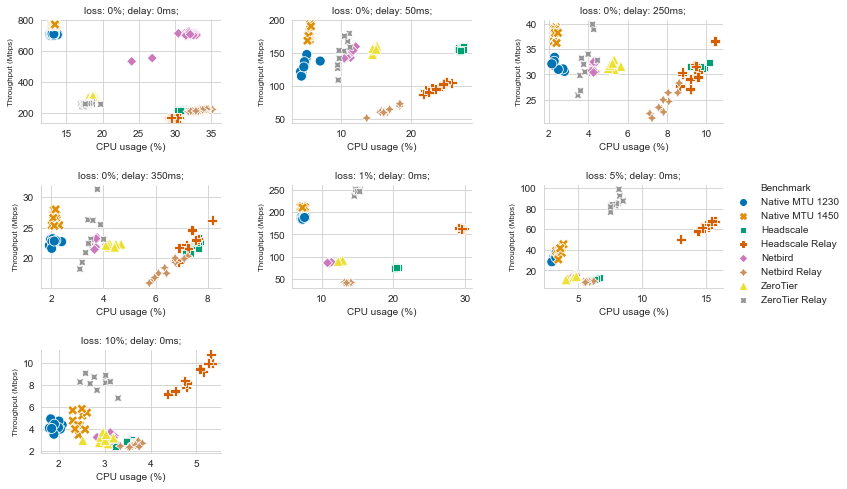

In [7]:
pod2pod_tcp_scatter_v2 = sns.relplot(data=pod2pod_tcp_exec, x='client-cpu', y='bandwidth', col='conditions',
                 hue='benchmark-name', style='benchmark-name',
                 col_wrap=3, height=2.3, aspect=1.5,
                 col_order=['loss: 0%; delay: 0ms;', 'loss: 0%; delay: 50ms;', 'loss: 0%; delay: 250ms;', 'loss: 0%; delay: 350ms;','loss: 1%; delay: 0ms;', 'loss: 5%; delay: 0ms;', 'loss: 10%; delay: 0ms;'],
                 facet_kws={'sharey': False, 'sharex': False},
                 palette = ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#ece133', '#949494'],
                 s=100
             )
for ax in pod2pod_tcp_scatter_v2.axes.ravel():
    ax.set_ylabel('Throughput (Mbps)', fontsize=8)
    ax.set_xlabel('CPU usage (%)')
pod2pod_tcp_scatter_v2._legend.set_title('Benchmark')
pod2pod_tcp_scatter_v2.set_titles('{col_name}')
plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.show()
pod2pod_tcp_scatter_v2.savefig('figures/01-tcp-throughput-cpu-scatter-plot-v2.png', bbox_inches='tight', dpi=300)

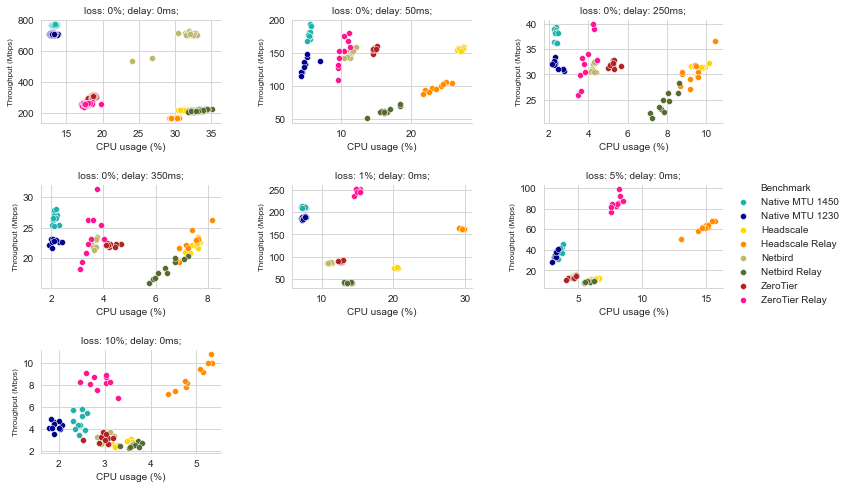

In [8]:
pod2pod_tcp_scatter = sns.FacetGrid(pod2pod_tcp_exec, col='conditions', hue='benchmark-name', sharex=False, sharey=False,
                                    col_wrap=3,
                                    height=2.3, aspect=1.5, col_order=['loss: 0%; delay: 0ms;', 'loss: 0%; delay: 50ms;', 'loss: 0%; delay: 250ms;', 'loss: 0%; delay: 350ms;','loss: 1%; delay: 0ms;', 'loss: 5%; delay: 0ms;', 'loss: 10%; delay: 0ms;'], hue_order=BENCHMARK_ORDER, palette=['lightseagreen', 'darkblue', 'gold', 'darkorange', 'darkkhaki', 'darkolivegreen', 'firebrick', 'deeppink']
                                    )
pod2pod_tcp_scatter = pod2pod_tcp_scatter.map(sns.scatterplot, 'client-cpu', 'bandwidth')
for ax in pod2pod_tcp_scatter.axes.ravel():
    ax.set_ylabel('Throughput (Mbps)', fontsize=8)
    ax.set_xlabel('CPU usage (%)')
pod2pod_tcp_scatter.add_legend(title='Benchmark')
pod2pod_tcp_scatter.set_titles('{col_name}')
plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.show()
# pod2pod_tcp_scatter.savefig('figures/01-tcp-throughput-cpu-scatter-plot.png', bbox_inches='tight', dpi=300)

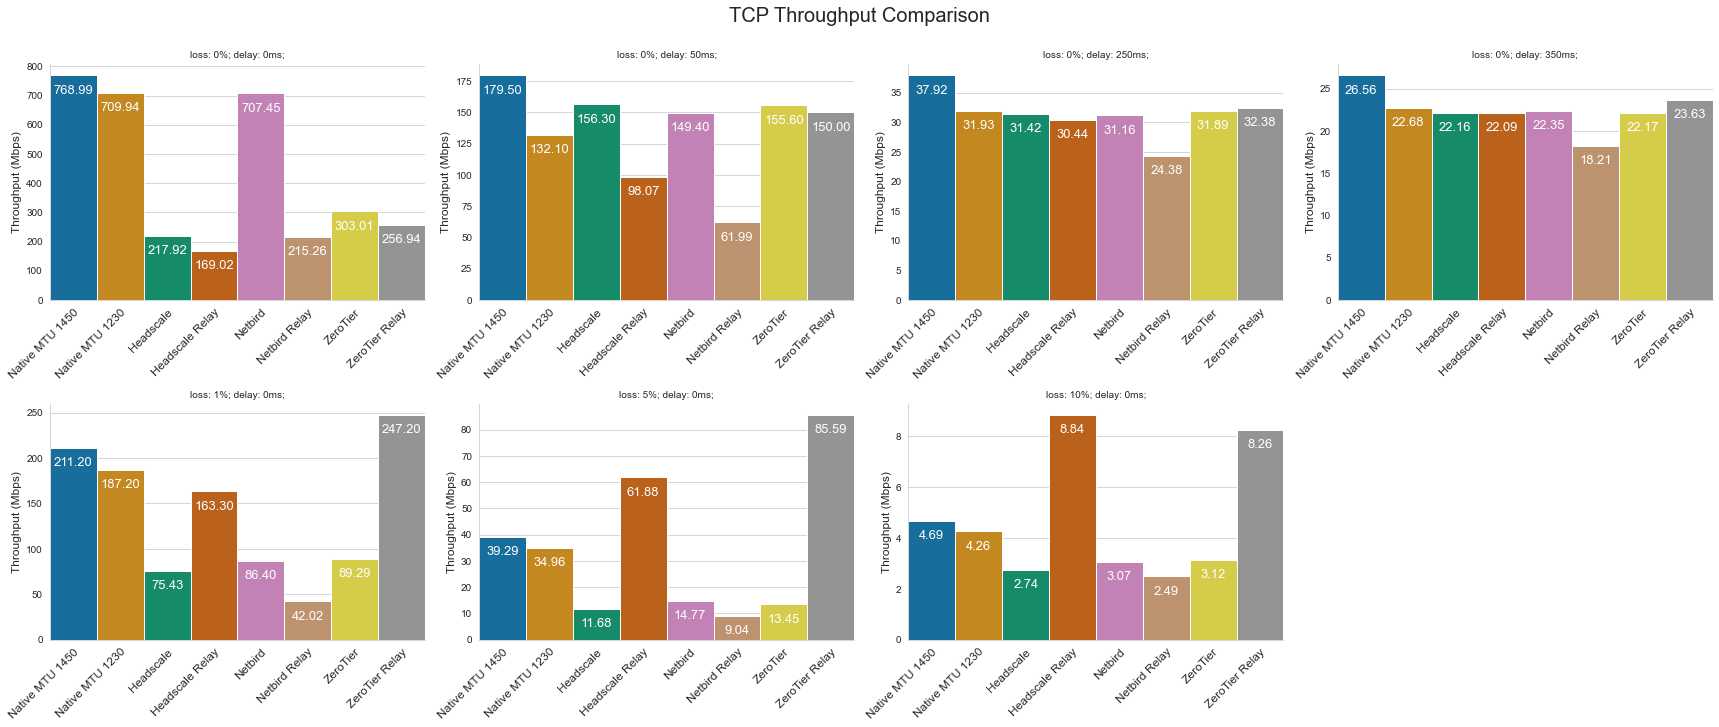

In [9]:
pod2pod_tcp_fg_v2 = sns.FacetGrid(pod2pod_tcp_exec_mean, col='conditions', hue='benchmark-name', sharex=False,
                               sharey=False,
                               col_wrap=4,
                               height=5, aspect=1.20,
                               palette=['#029e73', '#d55e00', '#de8f05', '#0173b2', '#cc78bc', '#ca9161', '#ece133', '#949494'],
                                  # palette=['gold', 'darkorange', 'darkblue', 'lightseagreen', 'darkkhaki',
                                  #          'darkolivegreen', 'firebrick', 'deeppink']
                                  )
pod2pod_tcp_fg_v2 = pod2pod_tcp_fg_v2.map(sns.barplot, 'benchmark-name', 'bandwidth', errorbar="sd", order=BENCHMARK_ORDER,
                                    width=1)

for axes in pod2pod_tcp_fg_v2.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, fontsize=12, rotation_mode='anchor', ha='right')

pod2pod_tcp_fg_v2.fig.tight_layout(w_pad=3)
for ax in pod2pod_tcp_fg_v2.axes.ravel():
    ax.set_ylabel('Throughput (Mbps)', fontsize=12)
    ax.set_xlabel('')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                    va='center', xytext=(0, -15), textcoords='offset points', fontsize=13, color='white')

pod2pod_tcp_fg_v2.fig.suptitle('TCP Throughput Comparison', fontsize=20, y=1.005)
pod2pod_tcp_fg_v2.set_titles('{col_name}')
plt.tight_layout()
# pod2pod_tcp_fg_v2.savefig('figures/02-tcp-throughput-mean-bar-plot-v2.png', bbox_inches='tight', dpi=300)

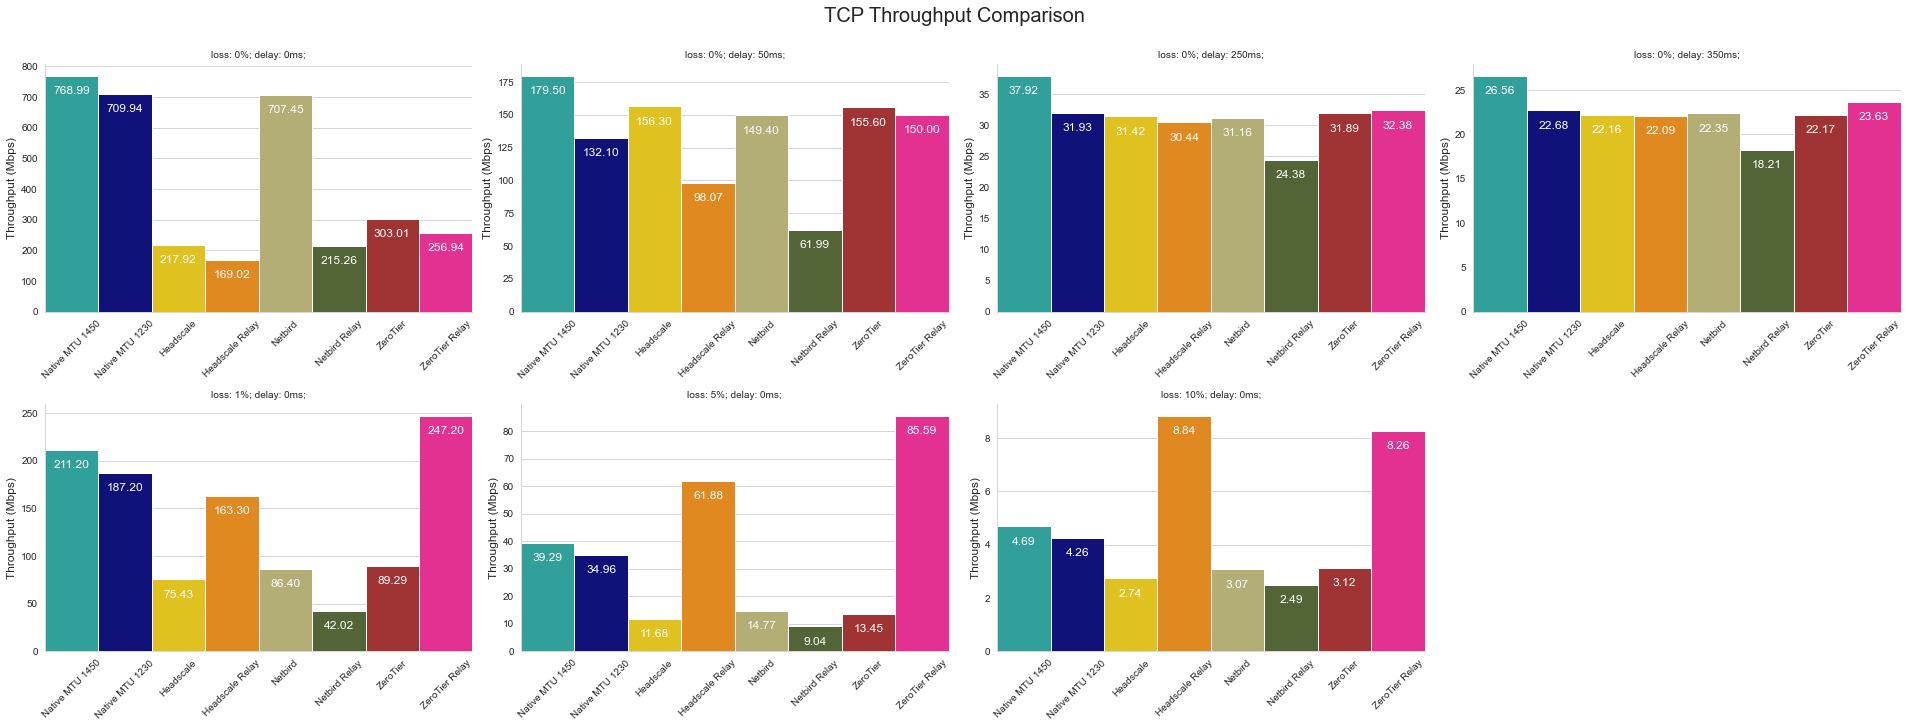

In [10]:
pod2pod_tcp_fg = sns.FacetGrid(pod2pod_tcp_exec_mean, col='conditions', hue='benchmark-name', sharex=False,
                               sharey=False,
                               col_wrap=4,
                               height=5, aspect=1.33,
                               palette=['gold', 'darkorange', 'darkblue', 'lightseagreen', 'darkkhaki',
                                        'darkolivegreen', 'firebrick', 'deeppink'])
pod2pod_tcp_fg = pod2pod_tcp_fg.map(sns.barplot, 'benchmark-name', 'bandwidth', errorbar="sd", order=BENCHMARK_ORDER,
                                    width=1)

for axes in pod2pod_tcp_fg.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45)

pod2pod_tcp_fg.fig.tight_layout(w_pad=3)
for ax in pod2pod_tcp_fg.axes.ravel():
    ax.set_ylabel('Throughput (Mbps)', fontsize=12)
    ax.set_xlabel('')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                    va='center', xytext=(0, -15), textcoords='offset points', fontsize=12, color='white')

pod2pod_tcp_fg.fig.suptitle('TCP Throughput Comparison', fontsize=20, y=1.005)
pod2pod_tcp_fg.set_titles('{col_name}')
plt.tight_layout()
# pod2pod_tcp_fg.savefig('figures/02-tcp-throughput-mean-bar-plot.png', bbox_inches='tight', dpi=300)

In [11]:
# For descriptive statistics
# pod2pod_tcp_exec
descriptive_tcp = pod2pod_tcp_exec[["bandwidth", "benchmark-name", "conditions"]].groupby(["benchmark-name", "conditions"]).describe()
descriptive_tcp.to_csv('descriptive-tcp.csv')
descriptive_tcp

bandwidth                         \
                                            count        mean        std   
benchmark-name  conditions                                                 
Headscale       loss: 0%; delay: 0ms;       100.0  217.920000   2.493142   
                loss: 0%; delay: 250ms;      10.0   31.420000   0.676264   
                loss: 0%; delay: 350ms;      10.0   22.160000   0.828922   
                loss: 0%; delay: 50ms;       10.0  156.300000   2.451757   
                loss: 1%; delay: 0ms;        10.0   75.430000   1.100555   
                loss: 10%; delay: 0ms;       10.0    2.737000   0.196754   
                loss: 5%; delay: 0ms;        10.0   11.680000   0.672970   
Headscale Relay loss: 0%; delay: 0ms;       100.0  169.020000   0.696020   
                loss: 0%; delay: 250ms;      10.0   30.440000   2.644995   
                loss: 0%; delay: 350ms;      10.0   22.090000   2.270316   
                loss: 0%; delay: 50ms;       10.0   98.070000   6.620683   
                loss: 1%; delay: 0ms;        10.0  163.300000   0.674949   
                loss: 10%; delay: 0ms;       10.0    8.841000   1.217780   
                loss: 5%; delay: 0ms;        10.0   61.880000   5.069035   
Native MTU 1230 loss: 0%; delay: 0ms;       100.0  709.940000   2.891366   
                loss: 0%; delay: 250ms;      10.0   31.930000   0.840701   
                loss: 0%; delay: 350ms;      10.0   22.680000   0.484883   
                loss: 0%; delay: 50ms;       10.0  132.100000  10.461039   
                loss: 1%; delay: 0ms;        10.0  187.200000   2.440401   
                loss: 10%; delay: 0ms;       10.0    4.261000   0.419880   
                loss: 5%; delay: 0ms;        10.0   34.960000   3.404311   
Native MTU 1450 loss: 0%; delay: 0ms;       100.0  768.990000   2.236045   
                loss: 0%; delay: 250ms;      10.0   37.920000   1.173598   
                loss: 0%; delay: 350ms;      10.0   26.560000   0.983418   
                loss: 0%; delay: 50ms;       10.0  179.500000   8.072587   
                loss: 1%; delay: 0ms;        10.0  211.200000   1.398412   
                loss: 10%; delay: 0ms;       10.0    4.686000   0.819705   
                loss: 5%; delay: 0ms;        10.0   39.290000   3.978679   
Netbird         loss: 0%; delay: 0ms;       100.0  707.450000  24.159560   
                loss: 0%; delay: 250ms;      10.0   31.160000   0.798888   
                loss: 0%; delay: 350ms;      10.0   22.350000   0.694822   
                loss: 0%; delay: 50ms;       10.0  149.400000   5.853774   
                loss: 1%; delay: 0ms;        10.0   86.400000   0.721110   
                loss: 10%; delay: 0ms;       10.0    3.073000   0.325066   
                loss: 5%; delay: 0ms;        10.0   14.770000   1.099545   
Netbird Relay   loss: 0%; delay: 0ms;        99.0  215.262626   4.313211   
                loss: 0%; delay: 250ms;      10.0   24.380000   2.174499   
                loss: 0%; delay: 350ms;      10.0   18.210000   1.595445   
                loss: 0%; delay: 50ms;       10.0   61.990000   6.008411   
                loss: 1%; delay: 0ms;        10.0   42.020000   0.664664   
                loss: 10%; delay: 0ms;       10.0    2.490000   0.198382   
                loss: 5%; delay: 0ms;        10.0    9.038000   0.570084   
ZeroTier        loss: 0%; delay: 0ms;       100.0  303.010000   6.650731   
                loss: 0%; delay: 250ms;      10.0   31.890000   0.624411   
                loss: 0%; delay: 350ms;      10.0   22.170000   0.231181   
                loss: 0%; delay: 50ms;       10.0  155.600000   3.533962   
                loss: 1%; delay: 0ms;        10.0   89.290000   1.397975   
                loss: 10%; delay: 0ms;       10.0    3.124000   0.338073   
                loss: 5%; delay: 0ms;        10.0   13.450000   1.358308   
ZeroTier Relay  loss: 0%; delay: 0ms;       100.0  256.940000   5.511824   
            

In [12]:
alpha = 0.05
CONDITIONS = ['loss: 0%; delay: 50ms;','loss: 0%; delay: 250ms;','loss: 0%; delay: 350ms;',
             'loss: 1%; delay: 0ms;', 'loss: 5%; delay: 0ms;', 'loss: 10%; delay: 0ms;',
             'loss: 0%; delay: 0ms;']

for i in itertools.combinations(BENCHMARK_ORDER,2):
    for j in CONDITIONS:
        test_a = pod2pod_tcp_exec[(pod2pod_tcp_exec['benchmark-name'] == i[0]) & (pod2pod_tcp_exec.conditions == j)]['bandwidth']
        test_b = pod2pod_tcp_exec[(pod2pod_tcp_exec['benchmark-name'] == i[1]) & (pod2pod_tcp_exec.conditions == j)]['bandwidth']
        statistic, pvalue = stats.mannwhitneyu(test_a, test_b, alternative='two-sided')
        if pvalue > alpha:
            print(f'test1={i[0]}; test2={i[1]}, con={j} Fail to reject H0 - same distribution (statistic={statistic})(p={pvalue})')
        else:
            # print(f'Reject H0 - different distribution (statistic={statistic})(p={pvalue})')
            pass

test1=Native MTU 1450; test2=Native MTU 1230, con=loss: 10%; delay: 0ms; Fail to reject H0 - same distribution (statistic=62.5)(p=0.36416573464017166)
test1=Native MTU 1230; test2=Headscale, con=loss: 0%; delay: 250ms; Fail to reject H0 - same distribution (statistic=68.0)(p=0.18438486520501984)
test1=Native MTU 1230; test2=Headscale, con=loss: 0%; delay: 350ms; Fail to reject H0 - same distribution (statistic=72.5)(p=0.0934227485217486)
test1=Native MTU 1230; test2=Headscale Relay, con=loss: 0%; delay: 350ms; Fail to reject H0 - same distribution (statistic=59.5)(p=0.4951545345257743)
test1=Native MTU 1230; test2=Netbird, con=loss: 0%; delay: 250ms; Fail to reject H0 - same distribution (statistic=76.0)(p=0.053181716468782836)
test1=Native MTU 1230; test2=Netbird, con=loss: 0%; delay: 350ms; Fail to reject H0 - same distribution (statistic=61.0)(p=0.4256100315999112)
test1=Native MTU 1230; test2=Netbird, con=loss: 0%; delay: 0ms; Fail to reject H0 - same distribution (statistic=4652.0

In [13]:
alpha = 0.05
CONDITIONS = [
              'loss: 0%; delay: 0ms;']

for i in itertools.combinations(BENCHMARK_ORDER,2):
    for j in CONDITIONS:
        test_a = pod2pod_tcp_exec[(pod2pod_tcp_exec['benchmark-name'] == i[0]) & (pod2pod_tcp_exec.conditions == j)]['bandwidth']
        test_b = pod2pod_tcp_exec[(pod2pod_tcp_exec['benchmark-name'] == i[1]) & (pod2pod_tcp_exec.conditions == j)]['bandwidth']
        statistic, pvalue = stats.mannwhitneyu(test_a, test_b, alternative='two-sided')
        if pvalue > alpha:
            print(f'test1={i[0]}; test2={i[1]}, con={j} Fail to reject H0 - same distribution (statistic={statistic})(p={pvalue})')
        else:
            # print(f'Reject H0 - different distribution (statistic={statistic})(p={pvalue})')
            pass

test1=Native MTU 1230; test2=Netbird, con=loss: 0%; delay: 0ms; Fail to reject H0 - same distribution (statistic=4652.0)(p=0.39388774680316996)


### Improved Bar Charts

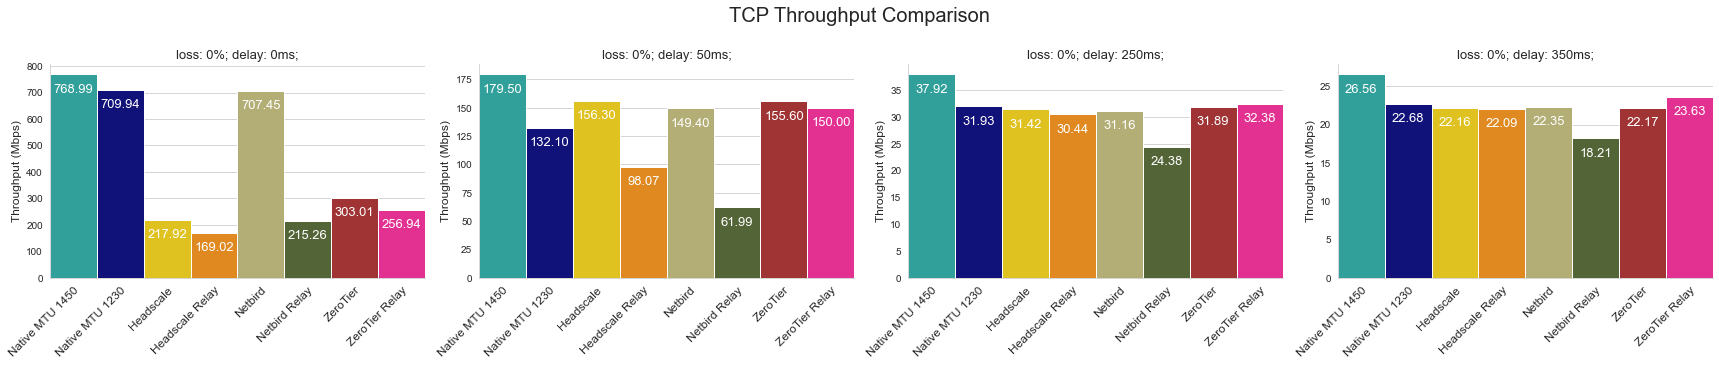

In [14]:
pod2pod_tcp_exec_mean_delay_only = pod2pod_tcp_exec_mean[(pod2pod_tcp_exec_mean['conditions']=='loss: 0%; delay: 0ms;') | (pod2pod_tcp_exec_mean['conditions']=='loss: 0%; delay: 50ms;') | (pod2pod_tcp_exec_mean['conditions']=='loss: 0%; delay: 250ms;') | (pod2pod_tcp_exec_mean['conditions']=='loss: 0%; delay: 350ms;')]

pod2pod_tcp_fg2 = sns.FacetGrid(pod2pod_tcp_exec_mean_delay_only, col='conditions', hue='benchmark-name', sharex=False,
                                sharey=False,
                                col_wrap=4,
                                height=5, aspect=1.20,
                                palette=['gold', 'darkorange', 'darkblue', 'lightseagreen', 'darkkhaki',
                                         'darkolivegreen', 'firebrick', 'deeppink'])
pod2pod_tcp_fg2 = pod2pod_tcp_fg2.map(sns.barplot, 'benchmark-name', 'bandwidth', errorbar="sd", order=BENCHMARK_ORDER,
                                      width=1)
#
for axes in pod2pod_tcp_fg2.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, fontsize=12, rotation_mode='anchor', ha='right')

pod2pod_tcp_fg2.fig.tight_layout(w_pad=3)
for ax in pod2pod_tcp_fg2.axes.ravel():
    ax.set_ylabel('Throughput (Mbps)', fontsize=12)
    ax.set_xlabel('')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                    va='center', xytext=(0, -15), textcoords='offset points', fontsize=13, color='white')

pod2pod_tcp_fg2.fig.suptitle('TCP Throughput Comparison', fontsize=20, y=1.005)
pod2pod_tcp_fg2.set_titles('{col_name}', size=13)
plt.tight_layout()
# pod2pod_tcp_fg2.savefig('figures/10-tcp-throughput-mean-bar-plot-delay-only.png', bbox_inches='tight', dpi=300)

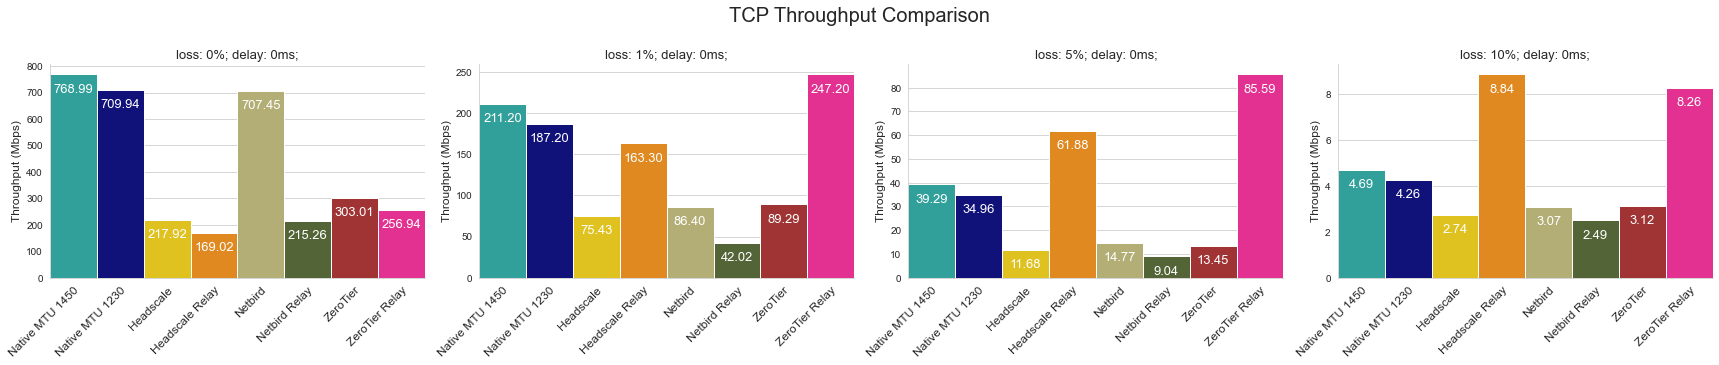

In [15]:
pod2pod_tcp_exec_mean_loss_only = pod2pod_tcp_exec_mean[(pod2pod_tcp_exec_mean['conditions']=='loss: 0%; delay: 0ms;') | (pod2pod_tcp_exec_mean['conditions']=='loss: 1%; delay: 0ms;') | (pod2pod_tcp_exec_mean['conditions']=='loss: 5%; delay: 0ms;') | (pod2pod_tcp_exec_mean['conditions']=='loss: 10%; delay: 0ms;')]

pod2pod_tcp_fg3 = sns.FacetGrid(pod2pod_tcp_exec_mean_loss_only, col='conditions', hue='benchmark-name', sharex=False,
                                sharey=False,
                                col_wrap=4,
                                height=5, aspect=1.20,
                                palette=['gold', 'darkorange', 'darkblue', 'lightseagreen', 'darkkhaki',
                                         'darkolivegreen', 'firebrick', 'deeppink'])
pod2pod_tcp_fg3 = pod2pod_tcp_fg3.map(sns.barplot, 'benchmark-name', 'bandwidth', errorbar="sd", order=BENCHMARK_ORDER,
                                      width=1)
#
for axes in pod2pod_tcp_fg3.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, fontsize=12, rotation_mode='anchor', ha='right')

pod2pod_tcp_fg3.fig.tight_layout(w_pad=3)
for ax in pod2pod_tcp_fg3.axes.ravel():
    ax.set_ylabel('Throughput (Mbps)', fontsize=12)
    ax.set_xlabel('')
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                    va='center', xytext=(0, -15), textcoords='offset points', fontsize=13, color='white')

pod2pod_tcp_fg3.fig.suptitle('TCP Throughput Comparison', fontsize=20, y=1.005)
pod2pod_tcp_fg3.set_titles('{col_name}', size=13)
plt.tight_layout()
# pod2pod_tcp_fg3.savefig('figures/11-tcp-throughput-mean-bar-plot-loss-only.png', bbox_inches='tight', dpi=300)

## Pod2Pod UDP

In [16]:
pod2pod_udp_exec = df_input[
    df_input['benchmark-type'].eq('pod2pod') &
    df_input['transport-protocol'].eq('udp')
    ]

pod2pod_udp_exec = pod2pod_udp_exec.replace(BENCHMARK_NAMES_MAP)
pod2pod_udp_exec['conditions'] = 'loss: '+pod2pod_udp_exec['loss'].map(str)+'%; delay: '+pod2pod_udp_exec['delay'].map(str)+'ms;'
pod2pod_udp_exec = pod2pod_udp_exec[
    (pod2pod_udp_exec['bandwidth'] >= 0) &
    (pod2pod_udp_exec['client-ram'] >= 0) &
    (pod2pod_udp_exec['client-cpu'] >= 0) &
    (pod2pod_udp_exec['server-ram'] >= 0) &
    (pod2pod_udp_exec['server-cpu'] >= 0)
]

pod2pod_udp_exec_mean = pod2pod_udp_exec.groupby(['benchmark-name', 'loss', 'delay']).mean().reset_index()
pod2pod_udp_exec_mean['conditions'] = 'loss: '+pod2pod_udp_exec_mean['loss'].map(str)+'%; delay: '+pod2pod_udp_exec_mean['delay'].map(str)+'ms;'
pod2pod_udp_exec_mean

,benchmark-name,loss,delay,mtu,bandwidth,client-ram,client-cpu,server-ram,server-cpu,conditions
0,Headscale,0,0,1230.0,285.080000,1126.840000,41.632200,1348.200000,28.478200,loss: 0%; delay: 0ms;
1,Headscale,0,50,1230.0,187.500000,1155.700000,40.127000,1159.500000,22.135000,loss: 0%; delay: 50ms;
2,Headscale,0,250,1230.0,37.116667,1146.333333,40.105000,1126.500000,7.201667,loss: 0%; delay: 250ms;
3,Headscale,0,350,1230.0,26.566667,1151.777778,40.248889,1124.333333,5.977778,loss: 0%; delay: 350ms;
4,Headscale,1,0,1230.0,283.900000,1120.700000,41.409000,1374.100000,28.820000,loss: 1%; delay: 0ms;
5,Headscale,5,0,1230.0,289.200000,1172.500000,41.707000,1365.900000,28.481000,loss: 5%; delay: 0ms;
6,Headscale,10,0,1230.0,284.300000,1121.300000,41.511000,1353.200000,27.441000,loss: 10%; delay: 0ms;
7,Headscale Relay,0,0,1230.0,267.700000,772.780000,42.144900,861.940000,30.423000,loss: 0%; delay: 0ms;
8,Headscale Relay,0,50,1230.0,150.800000,715.800000,22.699000,826.100000,14.744000,loss: 0%; delay: 50ms;
9,Headscale Relay,0,250,1230.0,35.812500,731.125000,31.683750,791.500000,8.092500,loss: 0%; delay: 250ms;


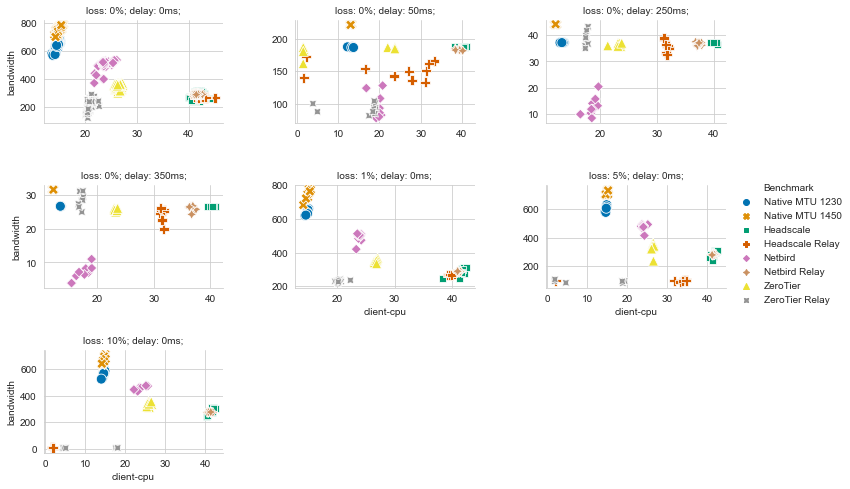

In [17]:
pod2pod_udp_scatter_v2 = sns.relplot(data=pod2pod_udp_exec, x='client-cpu', y='bandwidth', col='conditions',
                                     hue='benchmark-name', style='benchmark-name',
                                     col_wrap=3, height=2.3, aspect=1.5,
                                     col_order=['loss: 0%; delay: 0ms;', 'loss: 0%; delay: 50ms;', 'loss: 0%; delay: 250ms;', 'loss: 0%; delay: 350ms;','loss: 1%; delay: 0ms;', 'loss: 5%; delay: 0ms;', 'loss: 10%; delay: 0ms;'],
                                     facet_kws={'sharey': False, 'sharex': False},
                                     # palette=['lightseagreen', 'darkblue', 'gold', 'darkorange', 'darkkhaki', 'darkolivegreen', 'firebrick', 'deeppink'],
                                     # palette='colorblind',
                                     palette = ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#ece133', '#949494'],
                                     s=100
                                     )
for ax in pod2pod_tcp_scatter_v2.axes.ravel():
    ax.set_ylabel('Throughput (Mbps)', fontsize=8)
    ax.set_xlabel('CPU usage (%)')
pod2pod_udp_scatter_v2._legend.set_title('Benchmark')
pod2pod_udp_scatter_v2.set_titles('{col_name}')
plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.show()
# pod2pod_udp_scatter_v2.savefig('figures/03-udp-throughput-cpu-scatter-plot-v2.png', bbox_inches='tight', dpi=300)

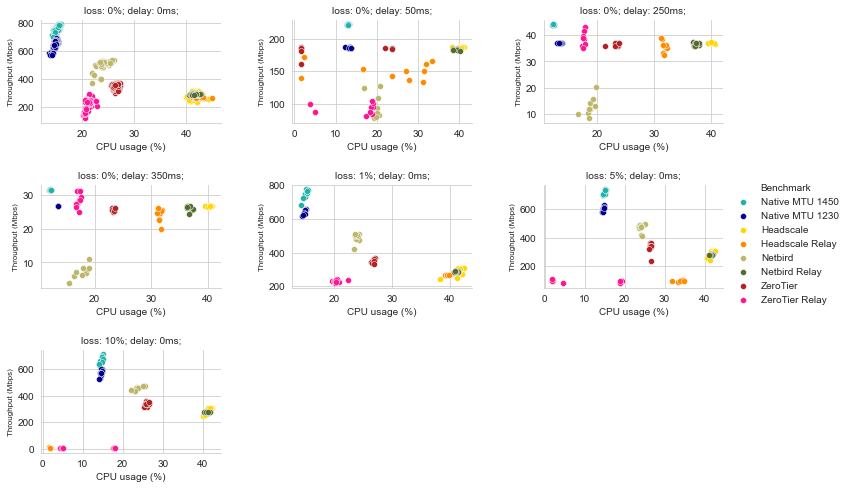

In [18]:
pod2pod_udp_scatter = sns.FacetGrid(pod2pod_udp_exec, col='conditions', hue='benchmark-name', sharex=False,
                                    sharey=False,
                                    col_wrap=3,
                                    height=2.3, aspect=1.5,
                                    col_order=['loss: 0%; delay: 0ms;', 'loss: 0%; delay: 50ms;',
                                               'loss: 0%; delay: 250ms;', 'loss: 0%; delay: 350ms;',
                                               'loss: 1%; delay: 0ms;', 'loss: 5%; delay: 0ms;',
                                               'loss: 10%; delay: 0ms;'], hue_order=BENCHMARK_ORDER,
                                    palette=['lightseagreen', 'darkblue', 'gold', 'darkorange', 'darkkhaki', 'darkolivegreen', 'firebrick', 'deeppink']
                                    )
pod2pod_udp_scatter = pod2pod_udp_scatter.map(sns.scatterplot, 'client-cpu', 'bandwidth')
for ax in pod2pod_udp_scatter.axes.ravel():
    ax.set_ylabel('Throughput (Mbps)', fontsize=8)
    ax.set_xlabel('CPU usage (%)')
pod2pod_udp_scatter.add_legend(title='Benchmark')
pod2pod_udp_scatter.set_titles('{col_name}')
plt.subplots_adjust(hspace=0.6, wspace=0.4)
plt.show()
# pod2pod_udp_scatter.savefig('figures/03-udp-throughput-cpu-scatter-plot.png', bbox_inches='tight', dpi=300)

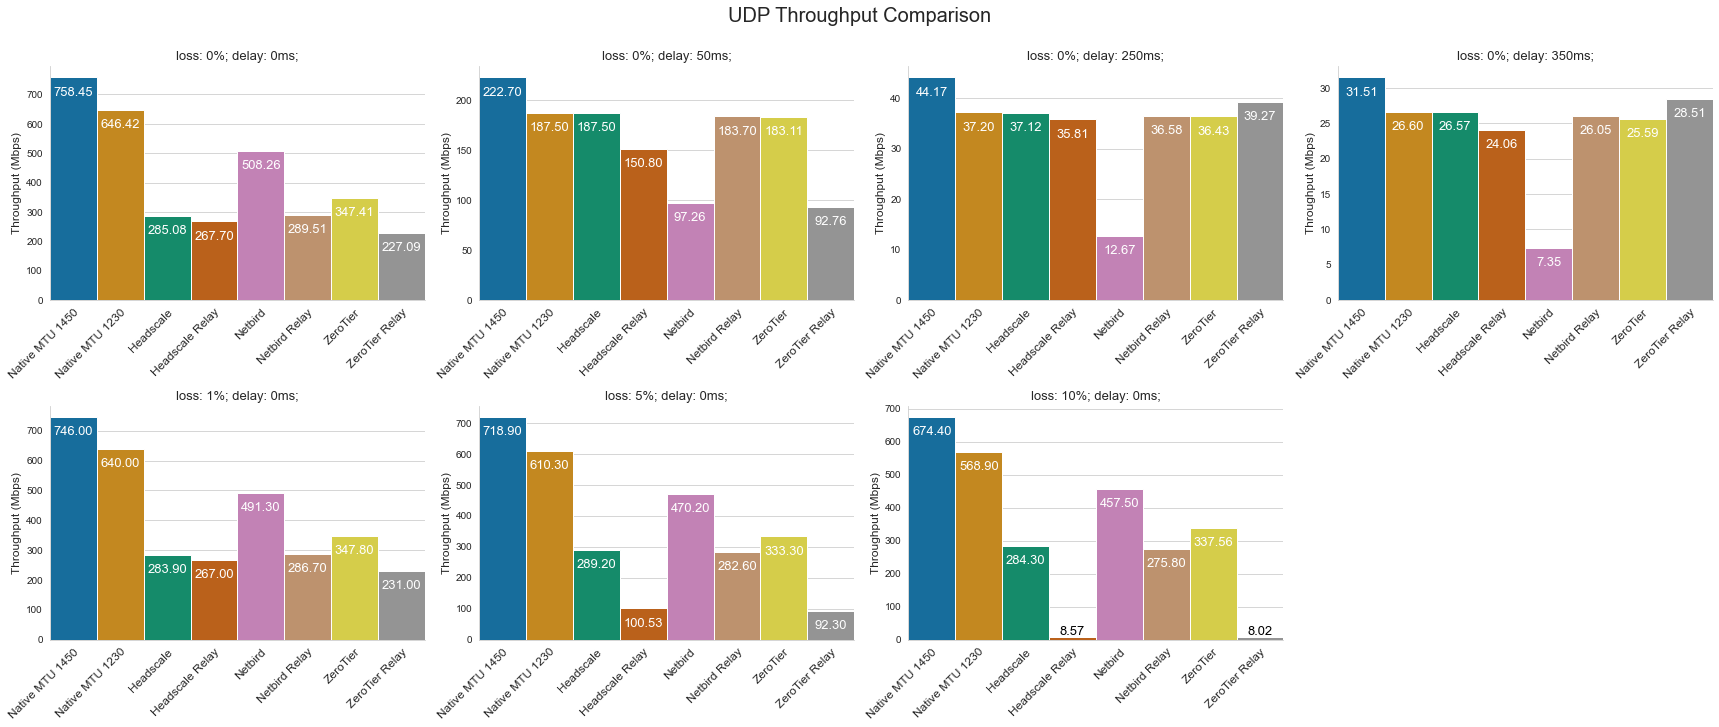

In [19]:
pod2pod_udp_fg_v2 = sns.FacetGrid(pod2pod_udp_exec_mean, col='conditions', hue='benchmark-name', sharex=False,
                               sharey=False,
                               col_wrap=4,
                               height=5, aspect=1.20,
                                  palette=['#029e73', '#d55e00', '#de8f05', '#0173b2', '#cc78bc', '#ca9161', '#ece133', '#949494'])
pod2pod_udp_fg_v2 = pod2pod_udp_fg_v2.map(sns.barplot, 'benchmark-name', 'bandwidth', order=BENCHMARK_ORDER, width=1)

for axes in pod2pod_udp_fg_v2.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45,fontsize=12, rotation_mode='anchor', ha='right')

pod2pod_udp_fg_v2.fig.tight_layout(w_pad=3)
for ax in pod2pod_udp_fg_v2.axes.ravel():
    ax.set_ylabel('Throughput (Mbps)', fontsize=12)
    ax.set_xlabel('')
    for p in ax.patches:
        if p.get_height() and 8.02<=p.get_height()<=8.7: # hacky way of displaying the number on top of the bar when the bar is too small to accomodate the text within itself
            ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                        va='center', xytext=(0, 5), textcoords='offset points', fontsize=13, color='black')
        else:
            ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                        va='center', xytext=(0, -15), textcoords='offset points', fontsize=13, color='white')

pod2pod_udp_fg_v2.fig.suptitle('UDP Throughput Comparison', fontsize=20, y=1.005)
pod2pod_udp_fg_v2.set_titles('{col_name}', size=13)
plt.tight_layout()
# pod2pod_udp_fg_v2.savefig('figures/04-udp-throughput-mean-bar-plot-v2.png', bbox_inches='tight', dpi=300)

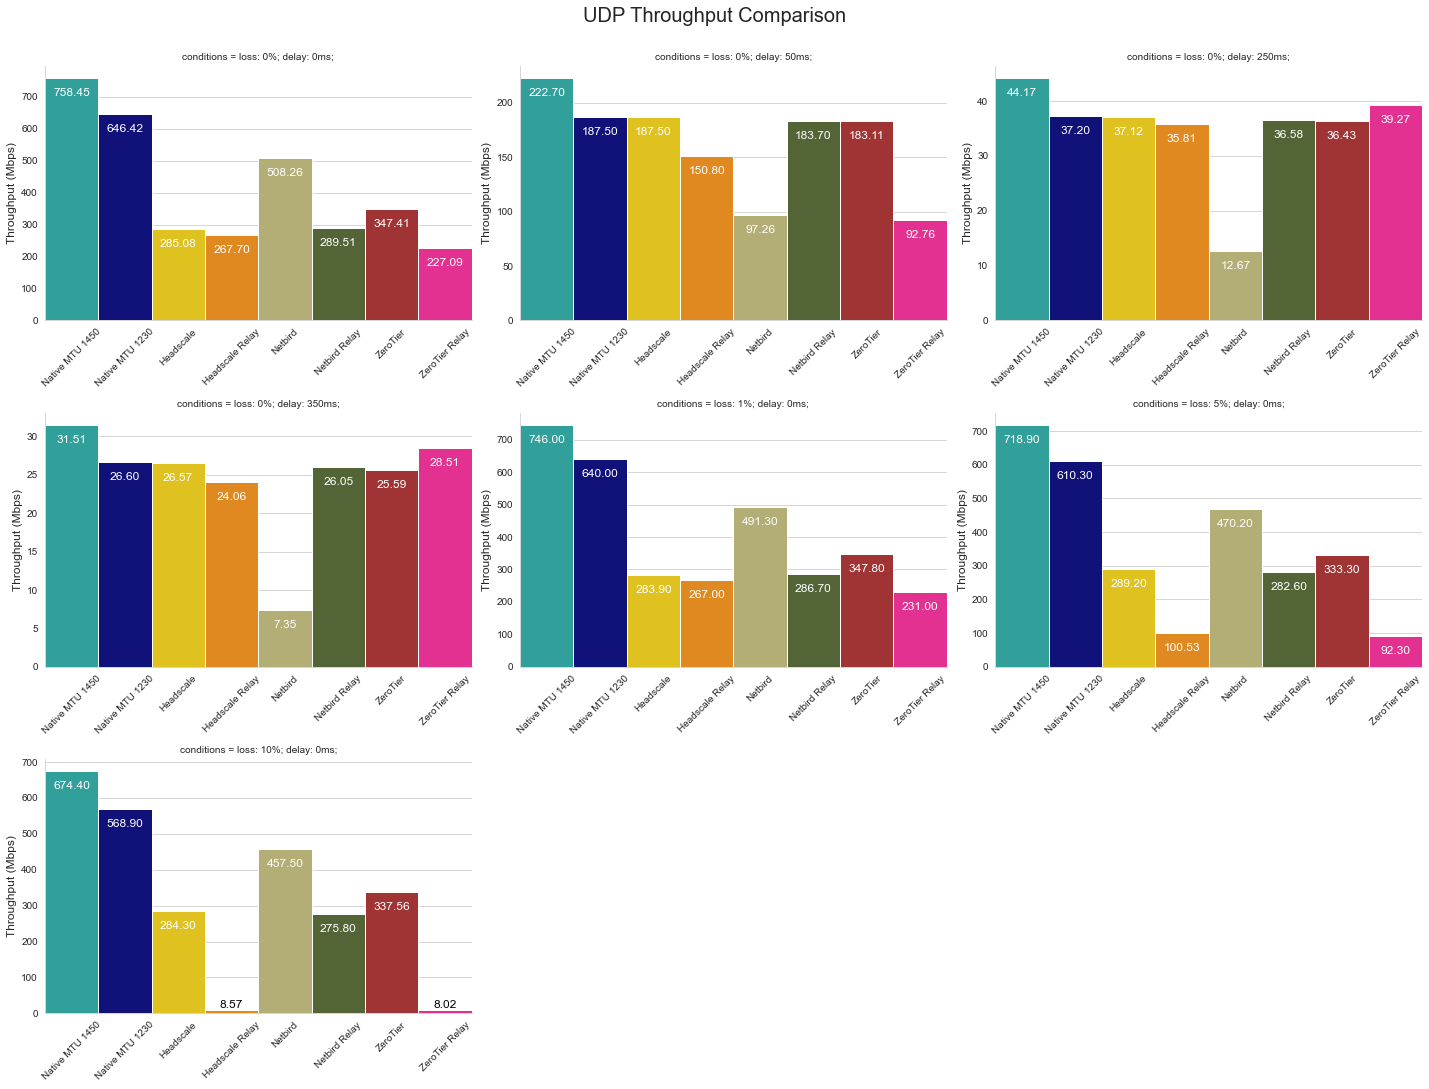

In [20]:
pod2pod_udp_fg = sns.FacetGrid(pod2pod_udp_exec_mean, col='conditions', hue='benchmark-name', sharex=False,
                               sharey=False,
                               col_wrap=3,
                               height=5, aspect=1.33,
                               palette=['gold', 'darkorange', 'darkblue', 'lightseagreen', 'darkkhaki',
                                        'darkolivegreen', 'firebrick', 'deeppink'])
pod2pod_udp_fg = pod2pod_udp_fg.map(sns.barplot, 'benchmark-name', 'bandwidth', order=BENCHMARK_ORDER, width=1)

for axes in pod2pod_udp_fg.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45)

pod2pod_udp_fg.fig.tight_layout(w_pad=3)
for ax in pod2pod_udp_fg.axes.ravel():
    ax.set_ylabel('Throughput (Mbps)', fontsize=12)
    ax.set_xlabel('')
    for p in ax.patches:
        if p.get_height() and 8.02<=p.get_height()<=8.7: # hacky way of displaying the number on top of the bar when the bar is too small to accomodate the text within itself
            ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                        va='center', xytext=(0, 5), textcoords='offset points', fontsize=12, color='black')
        else:
            ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                    va='center', xytext=(0, -15), textcoords='offset points', fontsize=12, color='white')

pod2pod_udp_fg.fig.suptitle('UDP Throughput Comparison', fontsize=20, y=1.005)
plt.tight_layout()
# pod2pod_udp_fg.savefig('figures/04-udp-throughput-mean-bar-plot.png', bbox_inches='tight', dpi=300)

In [21]:
descriptive_udp = pod2pod_udp_exec[["bandwidth", "benchmark-name", "conditions"]].groupby(["benchmark-name", "conditions"]).describe()
descriptive_udp.to_csv('descriptive-udp.csv')
descriptive_udp

bandwidth                         \
                                            count        mean        std   
benchmark-name  conditions                                                 
Headscale       loss: 0%; delay: 0ms;       100.0  285.080000  22.223693   
                loss: 0%; delay: 250ms;       6.0   37.116667   0.256255   
                loss: 0%; delay: 350ms;       9.0   26.566667   0.050000   
                loss: 0%; delay: 50ms;       10.0  187.500000   0.527046   
                loss: 1%; delay: 0ms;        10.0  283.900000  23.722704   
                loss: 10%; delay: 0ms;       10.0  284.300000  22.808624   
                loss: 5%; delay: 0ms;        10.0  289.200000  24.197337   
Headscale Relay loss: 0%; delay: 0ms;       100.0  267.700000   1.839521   
                loss: 0%; delay: 250ms;       8.0   35.812500   2.237625   
                loss: 0%; delay: 350ms;       9.0   24.055556   1.986902   
                loss: 0%; delay: 50ms;       10.0  150.800000  13.222876   
                loss: 1%; delay: 0ms;        10.0  267.000000   2.054805   
                loss: 10%; delay: 0ms;       10.0    8.571000   1.476877   
                loss: 5%; delay: 0ms;         9.0  100.533333   5.384236   
Native MTU 1230 loss: 0%; delay: 0ms;       100.0  646.420000  26.503737   
                loss: 0%; delay: 250ms;      10.0   37.200000   0.000000   
                loss: 0%; delay: 350ms;      10.0   26.600000   0.000000   
                loss: 0%; delay: 50ms;       10.0  187.500000   0.527046   
                loss: 1%; delay: 0ms;        10.0  640.000000  14.476034   
                loss: 10%; delay: 0ms;       10.0  568.900000  24.601039   
                loss: 5%; delay: 0ms;        10.0  610.300000  16.720247   
Native MTU 1450 loss: 0%; delay: 0ms;       100.0  758.450000  20.898202   
                loss: 0%; delay: 250ms;      10.0   44.170000   0.048305   
                loss: 0%; delay: 350ms;       9.0   31.511111   0.033333   
                loss: 0%; delay: 50ms;       10.0  222.700000   0.483046   
                loss: 1%; delay: 0ms;        10.0  746.000000  28.561824   
                loss: 10%; delay: 0ms;       10.0  674.400000  26.879153   
                loss: 5%; delay: 0ms;        10.0  718.900000  15.744135   
Netbird         loss: 0%; delay: 0ms;       100.0  508.260000  25.980031   
                loss: 0%; delay: 250ms;      10.0   12.668000   3.429978   
                loss: 0%; delay: 350ms;      10.0    7.346000   1.839035   
                loss: 0%; delay: 50ms;        8.0   97.262500  20.185917   
                loss: 1%; delay: 0ms;        10.0  491.300000  27.856976   
                loss: 10%; delay: 0ms;       10.0  457.500000  14.585000   
                loss: 5%; delay: 0ms;        10.0  470.200000  28.346272   
Netbird Relay   loss: 0%; delay: 0ms;       100.0  289.510000   3.418591   
                loss: 0%; delay: 250ms;      10.0   36.580000   0.575036   
                loss: 0%; delay: 350ms;      10.0   26.050000   0.770642   
                loss: 0%; delay: 50ms;       10.0  183.700000   1.059350   
                loss: 1%; delay: 0ms;        10.0  286.700000   2.584140   
                loss: 10%; delay: 0ms;       10.0  275.800000   2.043961   
                loss: 5%; delay: 0ms;        10.0  282.600000   2.913570   
ZeroTier        loss: 0%; delay: 0ms;        98.0  347.408163  14.958249   
                loss: 0%; delay: 250ms;       7.0   36.428571   0.573627   
                loss: 0%; delay: 350ms;       9.0   25.588889   0.388730   
                loss: 0%; delay: 50ms;        9.0  183.111111   8.207382   
                loss: 1%; delay: 0ms;        10.0  347.800000  10.549355   
                loss: 10%; delay: 0ms;        9.0  337.555556  15.125402   
                loss: 5%; delay: 0ms;        10.0  333.300000  35.823797   
ZeroTier Relay  loss: 0%; delay: 0ms;       100.0  227.090000  33.226828   
            

In [22]:
alpha = 0.05
CONDITIONS = ['loss: 0%; delay: 0ms;']

for i in itertools.combinations(BENCHMARK_ORDER,2):
    for j in CONDITIONS:
        test_a = pod2pod_udp_exec[(pod2pod_udp_exec['benchmark-name'] == i[0]) & (pod2pod_udp_exec.conditions == j)]['bandwidth']
        test_b = pod2pod_udp_exec[(pod2pod_udp_exec['benchmark-name'] == i[1]) & (pod2pod_udp_exec.conditions == j)]['bandwidth']
        statistic, pvalue = stats.mannwhitneyu(test_a, test_b, alternative='two-sided')
        if pvalue > alpha:
            print(f'test1={i[0]}; test2={i[1]}, con={j} Fail to reject H0 - same distribution (statistic={statistic})(p={pvalue})')
        else:
            print(f'Reject H0 - different distribution (statistic={statistic})(p={pvalue})')
            pass

Reject H0 - different distribution (statistic=10000.0)(p=2.538723228181968e-34)
Reject H0 - different distribution (statistic=10000.0)(p=2.5084325000799866e-34)
Reject H0 - different distribution (statistic=10000.0)(p=1.967353097222256e-34)
Reject H0 - different distribution (statistic=10000.0)(p=2.4953175827809624e-34)
Reject H0 - different distribution (statistic=10000.0)(p=2.3006970937913514e-34)
Reject H0 - different distribution (statistic=9800.0)(p=5.421268195348333e-34)
Reject H0 - different distribution (statistic=10000.0)(p=2.5337215465391058e-34)
Reject H0 - different distribution (statistic=10000.0)(p=2.5102711051215745e-34)
Reject H0 - different distribution (statistic=10000.0)(p=1.9688044229771863e-34)
Reject H0 - different distribution (statistic=10000.0)(p=2.497146829499213e-34)
Reject H0 - different distribution (statistic=10000.0)(p=2.3023873069712123e-34)
Reject H0 - different distribution (statistic=9800.0)(p=5.4253213253646994e-34)
Reject H0 - different distribution

### Improved Bar Charts

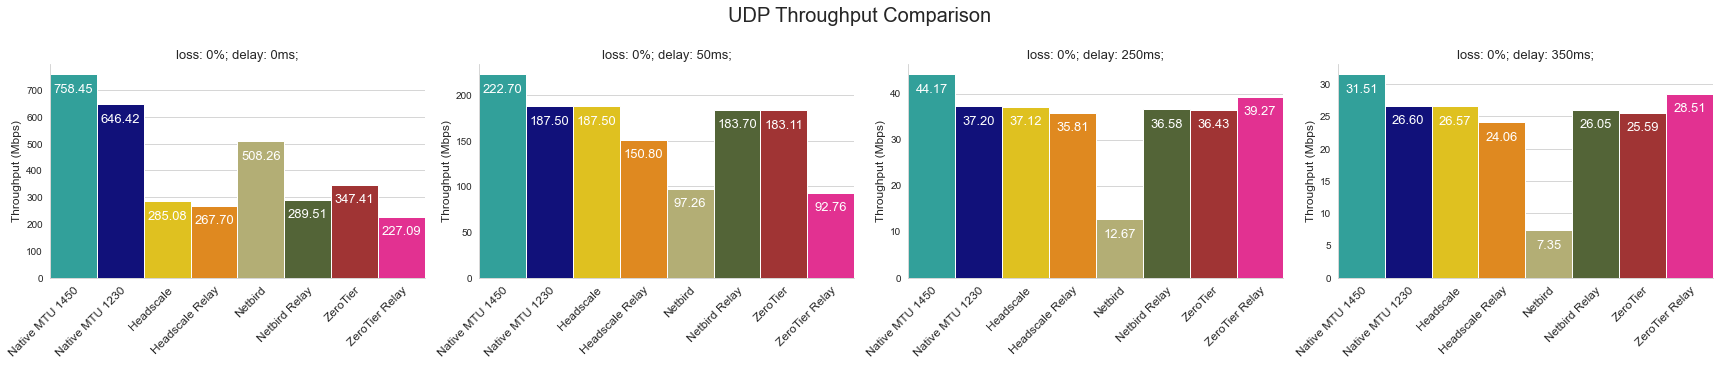

In [23]:
pod2pod_udp_exec_mean_loss_only = pod2pod_udp_exec_mean[(pod2pod_udp_exec_mean['conditions']=='loss: 0%; delay: 0ms;') | (pod2pod_udp_exec_mean['conditions']=='loss: 0%; delay: 50ms;') | (pod2pod_udp_exec_mean['conditions']=='loss: 0%; delay: 250ms;') | (pod2pod_udp_exec_mean['conditions']=='loss: 0%; delay: 350ms;')]

pod2pod_udp_fg3 = sns.FacetGrid(pod2pod_udp_exec_mean_loss_only, col='conditions', hue='benchmark-name', sharex=False,
                                sharey=False,
                                col_wrap=4,
                                height=5, aspect=1.20,
                                palette=['gold', 'darkorange', 'darkblue', 'lightseagreen', 'darkkhaki',
                                         'darkolivegreen', 'firebrick', 'deeppink'])
pod2pod_udp_fg3 = pod2pod_udp_fg3.map(sns.barplot, 'benchmark-name', 'bandwidth', order=BENCHMARK_ORDER, width=1)

for axes in pod2pod_udp_fg3.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, fontsize=12, rotation_mode='anchor', ha='right')

pod2pod_udp_fg3.fig.tight_layout(w_pad=3)
for ax in pod2pod_udp_fg3.axes.ravel():
    ax.set_ylabel('Throughput (Mbps)', fontsize=12)
    ax.set_xlabel('')
    for p in ax.patches:
        if p.get_height() and 8.02<=p.get_height()<=8.7: # hacky way of displaying the number on top of the bar when the bar is too small to accomodate the text within itself
            ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                        va='center', xytext=(0, 5), textcoords='offset points', fontsize=13, color='black')
        else:
            ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                        va='center', xytext=(0, -15), textcoords='offset points', fontsize=13, color='white')

pod2pod_udp_fg3.fig.suptitle('UDP Throughput Comparison', fontsize=20, y=1.005)
pod2pod_udp_fg3.set_titles('{col_name}', size=13)
plt.tight_layout()
# pod2pod_udp_fg3.savefig('figures/20-udp-throughput-mean-bar-plot-delay-only.png', bbox_inches='tight', dpi=300)

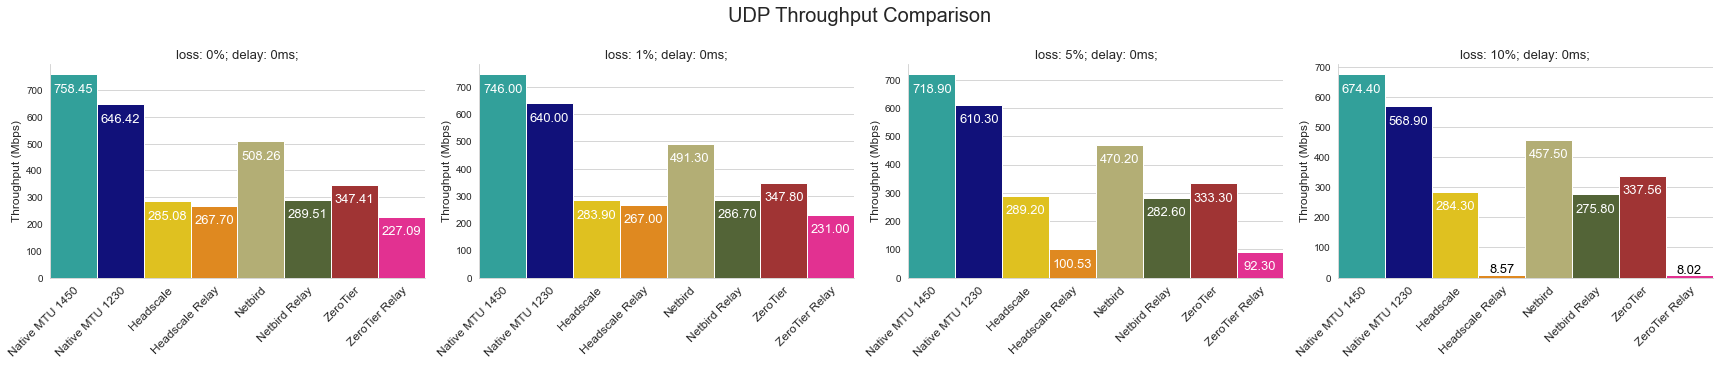

In [24]:
pod2pod_udp_exec_mean_loss_only = pod2pod_udp_exec_mean[(pod2pod_udp_exec_mean['conditions']=='loss: 0%; delay: 0ms;') | (pod2pod_udp_exec_mean['conditions']=='loss: 1%; delay: 0ms;') | (pod2pod_udp_exec_mean['conditions']=='loss: 5%; delay: 0ms;') | (pod2pod_udp_exec_mean['conditions']=='loss: 10%; delay: 0ms;')]

pod2pod_udp_fg4 = sns.FacetGrid(pod2pod_udp_exec_mean_loss_only, col='conditions', hue='benchmark-name', sharex=False,
                                sharey=False,
                                col_wrap=4,
                                height=5, aspect=1.20,
                                palette=['gold', 'darkorange', 'darkblue', 'lightseagreen', 'darkkhaki',
                                         'darkolivegreen', 'firebrick', 'deeppink'])
pod2pod_udp_fg4 = pod2pod_udp_fg4.map(sns.barplot, 'benchmark-name', 'bandwidth', order=BENCHMARK_ORDER, width=1)

for axes in pod2pod_udp_fg4.axes.flat:
    axes.set_xticklabels(axes.get_xticklabels(), rotation=45, fontsize=12, rotation_mode='anchor', ha='right')

pod2pod_udp_fg4.fig.tight_layout(w_pad=3)
for ax in pod2pod_udp_fg4.axes.ravel():
    ax.set_ylabel('Throughput (Mbps)', fontsize=12)
    ax.set_xlabel('')
    for p in ax.patches:
        if p.get_height() and 8.02<=p.get_height()<=8.7: # hacky way of displaying the number on top of the bar when the bar is too small to accomodate the text within itself
            ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                        va='center', xytext=(0, 5), textcoords='offset points', fontsize=13, color='black')
        else:
            ax.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center',
                        va='center', xytext=(0, -15), textcoords='offset points', fontsize=13, color='white')

pod2pod_udp_fg4.fig.suptitle('UDP Throughput Comparison', fontsize=20, y=1.005)
pod2pod_udp_fg4.set_titles('{col_name}', size=13)
plt.tight_layout()
# pod2pod_udp_fg4.savefig('figures/21-udp-throughput-mean-bar-plot-loss-only.png', bbox_inches='tight', dpi=300)

# Kubernetes API Server Response Time

In [25]:
k8s_api_results_path = Path('results-k8s-api')
df_k8s_api_results = pd.DataFrame()
for i in k8s_api_results_path.iterdir():
    for csv_file in i.glob('*.csv'):
        if csv_file.is_file():
            df_tmp = pd.read_csv(csv_file.resolve())
            df_tmp['benchmark']=i.name
            df_k8s_api_results = df_k8s_api_results.append(df_tmp)
df_k8s_api_results['benchmark'] = df_k8s_api_results['benchmark'].replace({
    '01-native-mtu1230-k8s-api-bench':'Native MTU 1230',
    '02-native-mtu1450-k8s-api-bench':'Native MTU 1450',
    '03-headscale-k8s-api-bench':'Headscale',
    '04-headscale-relay-k8s-api-bench':'Headscale Relay',
    '05-netbird-k8s-api-bench':'Netbird',
    '06-netbird-relay-k8s-api-bench':'Netbird Relay',
    '07-zerotier-k8s-api-bench':'ZeroTier',
    '08-zerotier-relay-k8s-api-bench':'ZeroTier Relay'
})
df_k8s_api_results

,response-time,DNS+dialup,DNS,Request-write,Response-delay,Response-read,status-code,offset,benchmark
0,0.0656,0.0367,0.0040,0.0000,0.0213,0.0075,200.0,0.1014,Native MTU 1230
1,0.1271,0.0435,0.0034,0.0000,0.0801,0.0034,200.0,0.1017,Native MTU 1230
2,0.1404,0.0338,0.0021,0.0001,0.1039,0.0026,200.0,0.1015,Native MTU 1230
3,0.1481,0.0435,0.0043,0.0000,0.1020,0.0026,200.0,0.1016,Native MTU 1230
4,0.1638,0.0377,0.0038,0.0000,0.1221,0.0037,200.0,0.1007,Native MTU 1230
...,...,...,...,...,...,...,...,...,...
4995,0.0430,0.0000,0.0000,0.0000,0.0386,0.0044,200.0,14.6199,ZeroTier Relay
4996,0.0445,0.0000,0.0000,0.0000,0.0381,0.0063,200.0,14.6186,ZeroTier Relay
4997,0.0211,0.0000,0.0000,0.0000,0.0134,0.0077,200.0,14.6450,ZeroTier Relay
4998,0.0148,0.0000,0.0000,0.0000,0.0125,0.0023,200.0,14.6536,ZeroTier Relay


In [26]:
df_k8s_api_results.groupby(['benchmark']).mean()

,response-time,DNS+dialup,DNS,Request-write,Response-delay,Response-read,status-code,offset
benchmark,,,,,,,,
Headscale,0.282484,0.000920,0.000093,0.000007,0.276140,0.005373,200.0,7.185551
Headscale Relay,0.292710,0.001039,0.000134,0.000007,0.281377,0.010249,200.0,7.449607
Native MTU 1230,0.248421,0.000836,0.000074,0.000006,0.242808,0.004719,200.0,6.284663
Native MTU 1450,0.249976,0.000799,0.000075,0.000005,0.244130,0.004991,200.0,6.364940
Netbird,0.277569,0.000875,0.000091,0.000007,0.270950,0.005683,200.0,7.043071
Netbird Relay,0.310095,0.001012,0.000154,0.000009,0.301042,0.007829,200.0,7.815252
ZeroTier,0.278726,0.000908,0.000084,0.000004,0.271450,0.006314,200.0,7.090014
ZeroTier Relay,0.290798,0.001783,0.000864,0.000004,0.281636,0.007326,200.0,7.325656


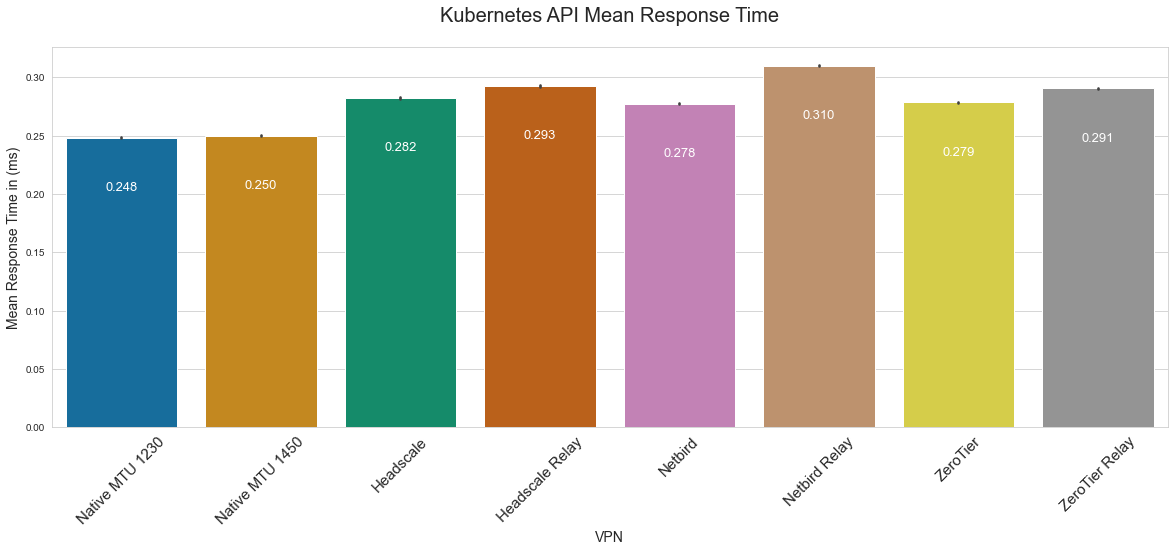

In [27]:
fig = plt.figure(figsize=(20, 7))
k8s_api_barplot_fg_v2 = sns.barplot(data=df_k8s_api_results, x='benchmark', y='response-time',
                                 # palette='colorblind',
                                    palette = ['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#ece133', '#949494'],)
for ax in k8s_api_barplot_fg_v2.patches:
    k8s_api_barplot_fg_v2.annotate(format(ax.get_height(), '.3f'), (ax.get_x() + ax.get_width() / 2., ax.get_height()),
                                ha='center', va='center', xytext=(0, -50), textcoords='offset points', fontsize=13, color='white')
k8s_api_barplot_fg_v2.set_xticklabels(k8s_api_barplot_fg_v2.get_xticklabels(), fontsize=15, rotation=45)
k8s_api_barplot_fg_v2.set_ylabel('Mean Response Time in (ms)', fontsize=14)
k8s_api_barplot_fg_v2.set_xlabel('VPN', fontsize=14)
k8s_api_barplot_fg_v2.set_title('Kubernetes API Mean Response Time', fontsize=20, y=1.05)
plt.show()
fig = k8s_api_barplot_fg_v2.get_figure()
# fig.savefig('figures/05-kubernetes-api-response-times-v2.png', bbox_inches='tight', dpi=300)

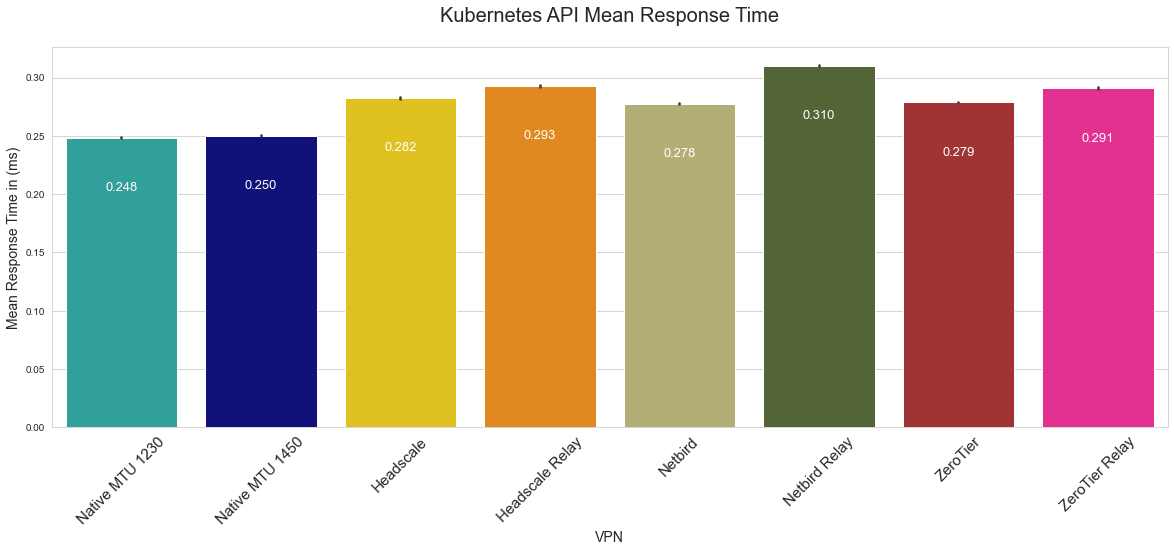

In [28]:
fig = plt.figure(figsize=(20, 7))
k8s_api_barplot_fg = sns.barplot(data=df_k8s_api_results, x='benchmark', y='response-time',
                                 palette=['lightseagreen', 'darkblue', 'gold', 'darkorange', 'darkkhaki',
                                          'darkolivegreen', 'firebrick', 'deeppink'])
for ax in k8s_api_barplot_fg.patches:
    k8s_api_barplot_fg.annotate(format(ax.get_height(), '.3f'), (ax.get_x() + ax.get_width() / 2., ax.get_height()),
                                ha='center', va='center', xytext=(0, -50), textcoords='offset points', fontsize=13, color='white')
k8s_api_barplot_fg.set_xticklabels(k8s_api_barplot_fg.get_xticklabels(), fontsize=15, rotation=45)
k8s_api_barplot_fg.set_ylabel('Mean Response Time in (ms)', fontsize=14)
k8s_api_barplot_fg.set_xlabel('VPN', fontsize=14)
k8s_api_barplot_fg.set_title('Kubernetes API Mean Response Time', fontsize=20, y=1.05)
plt.show()
fig = k8s_api_barplot_fg.get_figure()
fig.savefig('figures/05-kubernetes-api-response-times.png', bbox_inches='tight', dpi=300)

In [29]:
alpha = 0.05
for i in itertools.combinations(BENCHMARK_ORDER,2):
        test_a = df_k8s_api_results[(df_k8s_api_results['benchmark'] == i[0])]['response-time']
        test_b = df_k8s_api_results[(df_k8s_api_results['benchmark'] == i[1])]['response-time']
        statistic, pvalue = stats.mannwhitneyu(test_a, test_b, alternative='two-sided')
        if pvalue > alpha:
            print(f'test1={i[0]}; test2={i[1]} Fail to reject H0 - same distribution (statistic={statistic})(p={pvalue})')
        else:
            print(f'Reject H0 - different distribution (statistic={statistic})(p={pvalue})')
            pass

test_3 = df_k8s_api_results[(df_k8s_api_results['benchmark'] == 'Netbird')]['response-time']
test_4 = df_k8s_api_results[(df_k8s_api_results['benchmark'] == 'ZeroTier')]['response-time']
statistic, pvalue = stats.mannwhitneyu(test_3, test_4, alternative='two-sided')
print(statistic, pvalue)

test1=Native MTU 1450; test2=Native MTU 1230 Fail to reject H0 - same distribution (statistic=1246252848.0)(p=0.2200108537594596)
Reject H0 - different distribution (statistic=836397756.0)(p=0.0)
Reject H0 - different distribution (statistic=746749073.5)(p=0.0)
Reject H0 - different distribution (statistic=902747685.0)(p=0.0)
Reject H0 - different distribution (statistic=580538646.0)(p=0.0)
Reject H0 - different distribution (statistic=883572624.5)(p=0.0)
Reject H0 - different distribution (statistic=787526950.5)(p=0.0)
Reject H0 - different distribution (statistic=810171246.0)(p=0.0)
Reject H0 - different distribution (statistic=718217631.5)(p=0.0)
Reject H0 - different distribution (statistic=879255328.5)(p=0.0)
Reject H0 - different distribution (statistic=548311400.5)(p=0.0)
Reject H0 - different distribution (statistic=859179403.0)(p=0.0)
Reject H0 - different distribution (statistic=762296350.0)(p=0.0)
Reject H0 - different distribution (statistic=1132492824.0)(p=3.72347836437205